<a href="https://colab.research.google.com/github/gregor-posadas/Gregor-Projects/blob/main/WWTP_Heatmap_Correlation_Program_12A_(Process_Based_Correlation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modified**

Upload data files for the WWTP unit processes in sequence.
Enter the full path to the next process file (e.g., Influent): /content/Influent Parameters.csv
What is the name of this process? (e.g., Influent): Influent
Do you want to add another process file? (yes/no): yes
Enter the full path to the next process file (e.g., Influent): /content/Oxidation Ditch Effluent Parameters.xlsx
What is the name of this process? (e.g., Influent): Oxidation Ditch Effluent
Do you want to add another process file? (yes/no): yes
Enter the full path to the next process file (e.g., Influent): /content/Plant Effluent Parameters.xlsx
What is the name of this process? (e.g., Influent): Plant Effluent
Do you want to add another process file? (yes/no): no
Reading file: /content/Influent Parameters.csv
Applying Z-Score Method to filter outliers...
Finished processing file: /content/Influent Parameters.csv
Reading file: /content/Oxidation Ditch Effluent Parameters.xlsx
Applying Z-Score Method to filter outliers..

Generating heatmap between Oxidation Ditch Effluent and Plant Effluent...
Bootstrapping correlation matrices...
Bootstrapping iteration 0/500...
Bootstrapping iteration 100/500...
Bootstrapping iteration 200/500...
Bootstrapping iteration 300/500...
Bootstrapping iteration 400/500...
Bootstrapping iteration 0/500...
Bootstrapping iteration 100/500...
Bootstrapping iteration 200/500...
Bootstrapping iteration 300/500...
Bootstrapping iteration 400/500...
Bootstrapping iteration 0/500...
Bootstrapping iteration 100/500...
Bootstrapping iteration 200/500...
Bootstrapping iteration 300/500...
Bootstrapping iteration 400/500...
Calculating and correcting p-values...
Calculating p-values for correlation matrix...
Correcting p-values using Benjamini-Hochberg method...
Generating heatmap...


Generating network diagram for the processes...

Processing edge: Influent → Oxidation Ditch Effluent
Average Correlation: 0.06

Processing edge: Oxidation Ditch Effluent → Plant Effluent
Average Correlation: 0.05


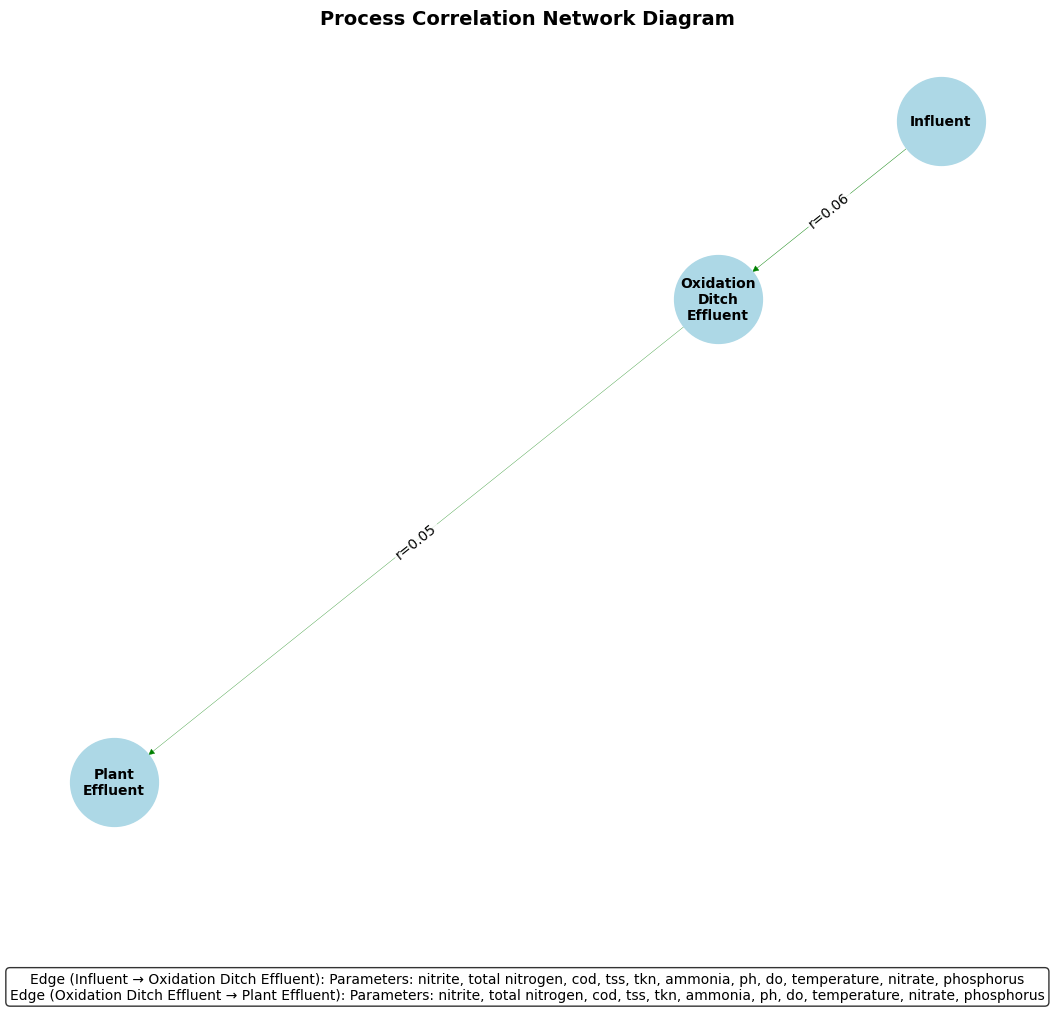

In [35]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import resample
import itertools
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize
from matplotlib import colormaps


# Function to remove outliers using Z-score
def remove_outliers_zscore(df, threshold=3):
    """
    Remove outliers from a DataFrame using the Z-score method.
    """
    print("Applying Z-Score Method to filter outliers...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy="omit"))
    mask = (z_scores < threshold).all(axis=1)
    return df[mask]


# Sequential file upload
def upload_files_sequentially():
    process_files = []
    process_labels = []

    while True:
        process_file = input("Enter the full path to the next process file (e.g., Influent): ")
        process_label = input(f"What is the name of this process? (e.g., Influent): ")

        process_files.append(process_file)
        process_labels.append(process_label)

        add_another = input("Do you want to add another process file? (yes/no): ").strip().lower()
        if add_another != 'yes':
            break

    return process_files, process_labels


# Read and align datasets with Z-score filtering
def read_file(file_path):
    """
    Read an Excel or CSV file into a DataFrame and normalize column names, with Z-score filtering.
    """
    try:
        print(f"Reading file: {file_path}")
        if file_path.endswith(".xlsx") or file_path.endswith(".xls"):
            df = pd.read_excel(file_path)
        elif file_path.endswith(".csv"):
            df = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported file format. Please use .xlsx, .xls, or .csv files.")

        df.columns = df.columns.str.lower().str.strip()
        if 'date' not in df.columns:
            raise KeyError(f"The file {file_path} does not contain a 'date' column.")
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=["date"])  # Drop rows with invalid dates
        df = remove_outliers_zscore(df)  # Apply Z-score filtering
        print(f"Finished processing file: {file_path}")
        return df
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        raise


# Statistical analysis
def bootstrap_correlations(df, n_iterations=500, method='pearson'):
    correlations = []
    for i in range(n_iterations):
        if i % 100 == 0:
            print(f"Bootstrapping iteration {i}/{n_iterations}...")
        df_resampled = resample(df)
        corr_matrix = df_resampled.corr(method=method)
        correlations.append(corr_matrix)

    median_corr = pd.concat(correlations).groupby(level=0).median()
    return median_corr


def calculate_p_values(df, method='pearson'):
    print("Calculating p-values for correlation matrix...")

    # Ensure all columns are numeric
    df = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')

    p_values = pd.DataFrame(np.ones((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    for col1, col2 in itertools.combinations(df.columns, 2):
        # Drop rows with NaN in either column
        valid_data = df[[col1, col2]].dropna()
        x = valid_data[col1]
        y = valid_data[col2]
        if len(x) > 1 and len(y) > 1:  # Pearson requires at least 2 data points
            _, p_val = stats.pearsonr(x, y)
            p_values.at[col1, col2] = p_val
            p_values.at[col2, col1] = p_val
    return p_values


def correct_p_values(p_values):
    print("Correcting p-values using Benjamini-Hochberg method...")
    _, corrected, _, _ = multipletests(p_values.values.flatten(), alpha=0.05, method='fdr_bh')
    corrected_p = pd.DataFrame(corrected.reshape(p_values.shape), index=p_values.index, columns=p_values.columns)
    return corrected_p


# Correlation validation function
def validate_correlation_matrix(df, n_iterations=500, alpha=0.05):
    """
    Validate correlations using bootstrapping and p-value correction.
    Returns a filtered correlation matrix with only significant values.
    """
    print("Bootstrapping correlation matrices...")

    # Ensure all columns are numeric
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna(axis=1, how='all')  # Drop columns that are entirely non-numeric or NaN

    pearson_corr = bootstrap_correlations(df, n_iterations=n_iterations, method='pearson')
    spearman_corr = bootstrap_correlations(df, n_iterations=n_iterations, method='spearman')
    kendall_corr = bootstrap_correlations(df, n_iterations=n_iterations, method='kendall')

    avg_corr_matrix = (pearson_corr + spearman_corr + kendall_corr) / 3
    #print("Average Correlation Matrix:\n", avg_corr_matrix)

    print("Calculating and correcting p-values...")
    p_values = calculate_p_values(df, method='pearson')
    corrected_p_values = correct_p_values(p_values)

    sig_mask = (corrected_p_values < alpha).astype(int)
    filtered_corr_matrix = avg_corr_matrix.where(sig_mask > 0).fillna(0)
    #print("Filtered Correlation Matrix:\n", filtered_corr_matrix)

    return filtered_corr_matrix


# Generate Heatmap
def generate_interactive_heatmap(df, title, labels):
    """
    Generate an interactive heatmap and return the filtered correlation matrix.
    """
    df = df.dropna().apply(pd.to_numeric, errors='coerce')

    print("Bootstrapping correlation matrices...")
    pearson_corr = bootstrap_correlations(df, n_iterations=500, method='pearson')
    spearman_corr = bootstrap_correlations(df, n_iterations=500, method='spearman')
    kendall_corr = bootstrap_correlations(df, n_iterations=500, method='kendall')

    avg_corr_matrix = (pearson_corr + spearman_corr + kendall_corr) / 3

    print("Calculating and correcting p-values...")
    pearson_p_values = calculate_p_values(df, method='pearson')
    corrected_p_values = correct_p_values(pearson_p_values)

    sig_mask = (corrected_p_values < 0.05).astype(int)
    filtered_corr_matrix = avg_corr_matrix.where(sig_mask > 0).fillna(0)

    parameter_order = sorted(filtered_corr_matrix.index)
    filtered_corr_matrix = filtered_corr_matrix.loc[parameter_order, parameter_order]

    np.fill_diagonal(filtered_corr_matrix.values, 1)

    print("Generating heatmap...")
    fig = px.imshow(
        filtered_corr_matrix,
        text_auto=".2f",
        color_continuous_scale="RdBu",
        zmin=-1,
        zmax=1,
        labels={"x": labels[0], "y": labels[1], "color": "Correlation Coefficient"},
        title=title,
    )

    fig.update_layout(
        title=dict(font=dict(size=20), x=0.5),
        xaxis=dict(tickangle=45, title=None, tickfont=dict(size=12)),
        yaxis=dict(title=None, tickfont=dict(size=12)),
        autosize=False,
        width=1200,
        height=1000,
        margin=dict(l=100, r=100, t=100, b=100),
    )

    fig.show()

    return filtered_corr_matrix



# Generate Network Diagram
def generate_network_diagram(labels, correlation_matrices, parameters_per_edge):
    """
    Generate a network diagram using precomputed correlation matrices.
    """
    G = nx.DiGraph()

    for i in range(len(labels) - 1):
        print(f"\nProcessing edge: {labels[i]} → {labels[i + 1]}")

        # Retrieve precomputed correlation matrix
        filtered_corr_matrix = correlation_matrices[i]

        # Compute average correlation directly from the matrix
        avg_corr = filtered_corr_matrix.mean().mean()
        print(f"Average Correlation: {avg_corr:.2f}")

        # Add edge to the graph
        G.add_edge(
            labels[i],
            labels[i + 1],
            weight=abs(avg_corr),
            correlation=avg_corr,
            parameters=parameters_per_edge[i]
        )

    # Format node labels with line breaks
    formatted_labels = {label: "\n".join(label.split(" ")) for label in labels}

    # Adjust layout dynamically
    num_nodes = len(G.nodes())
    k_value = 0.2 / num_nodes
    pos = nx.spring_layout(G, seed=42, k=k_value)

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)

    # Edge colors based on correlation sign
    edge_colors = ["green" if G[u][v]['correlation'] > 0 else "red" for u, v in G.edges()]
    edge_widths = [G[u][v]['weight'] * 5 for u, v in G.edges()]

    nx.draw(
        G,
        pos,
        labels=formatted_labels,
        with_labels=True,
        node_size=4000,
        node_color="lightblue",
        font_size=10,
        font_weight="bold",
        edge_color=edge_colors,
        width=edge_widths,
    )

    edge_labels = {
        (u, v): f"r={G[u][v]['correlation']:.2f}" for u, v in G.edges()
    }
    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels=edge_labels,
        font_size=10,
        bbox=dict(boxstyle="round,pad=0.2", edgecolor="none", facecolor="white", alpha=0.8),
        label_pos=0.5
    )

    text_box_content = "\n".join(
        [f"Edge ({labels[i]} → {labels[i + 1]}): Parameters: {', '.join(G[u][v]['parameters'])}" for i, (u, v) in enumerate(G.edges())]
    )
    ax = plt.gca()
    ax.text(
        0.5, -0.15,
        text_box_content,
        fontsize=10,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3", alpha=0.8),
        ha="center", va="top",
        transform=ax.transAxes
    )

    plt.title("Process Correlation Network Diagram", fontsize=14, pad=20, weight="bold")
    plt.show()


# Main Function
if __name__ == "__main__":
    print("Upload data files for the WWTP unit processes in sequence.")
    process_files, process_labels = upload_files_sequentially()

    # Validate file count
    if len(process_files) < 2:
        print("Error: You need at least 2 files to generate diagrams.")
        exit()

    # Read and process data files
    dataframes = [read_file(file) for file in process_files]

    # Find common parameters
    common_params = find_common_parameters(dataframes)
    if not common_params:
        print("Error: No common parameters found across the processes.")
        exit()

    # Track parameters for each edge
    parameters_per_edge = []
    for i in range(len(dataframes) - 1):
        df1 = dataframes[i][['date'] + common_params]
        df2 = dataframes[i + 1][['date'] + common_params]
        merged_df = pd.merge(df1, df2, on="date")

        # Identify parameters contributing to the correlation
        significant_params = [
            param for param in common_params
            if not merged_df[[f"{param}_x", f"{param}_y"]].corr().isnull().values.any()
        ]
        parameters_per_edge.append(significant_params)

    # Generate heatmaps for each pair of processes
    # Generate heatmaps and store correlation matrices
    correlation_matrices = []
    for i in range(len(process_files) - 1):
        print(f"Generating heatmap between {process_labels[i]} and {process_labels[i + 1]}...")
        merged_df = pd.merge(dataframes[i], dataframes[i + 1], on="date", suffixes=(f"_{process_labels[i]}", f"_{process_labels[i + 1]}"))
        title = f"Correlation Coefficient Heatmap: {process_labels[i]} vs {process_labels[i + 1]}"
        labels = (process_labels[i], process_labels[i + 1])
        filtered_corr_matrix = generate_interactive_heatmap(merged_df, title, labels)
        correlation_matrices.append(filtered_corr_matrix)

    # Generate network diagram using precomputed correlation matrices
    print("Generating network diagram for the processes...")
    generate_network_diagram(process_labels, correlation_matrices, parameters_per_edge)

